# Intro
3D object classification using VoxNet and LIDAR point cloud data (http://www.acfr.usyd.edu.au/papers/SydneyUrbanObjectsDataset.shtml)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
import os

from sklearn.model_selection import train_test_split

from tensorflow import keras
from mpl_toolkits import mplot3d

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import re
from sklearn.utils import class_weight


%matplotlib inline  

# Load data

In [2]:
def loadFile(fileName):
    names = ['t','intensity','id',
         'x','y','z',
         'azimuth','range','pid']

    formats = ['int64', 'uint8', 'uint8',
           'float32', 'float32', 'float32',
           'float32', 'float32', 'int32']

    binType = np.dtype( dict(names=names, formats=formats) )
    data = np.fromfile(fileName, binType)

    # 3D points, one per row
    P = np.vstack([ data['x'], data['y'], data['z'] ]).T
    
    return P

folderName = 'sydney-urban-objects-dataset/objects'

classes = ['4wd',
    'bench',
    'bicycle',
    'biker',
    'building',
    'bus',
    'car',
    'cyclist',
    'excavator',
    'pedestrian',
    'pillar',
    'pole',
    'post',
    'scooter',
    'ticket_machine',
    'traffic_lights',
    'traffic_sign',
    'trailer',
    'trash',
    'tree',
    'truck',
    'trunk',
    'umbrella',
    'ute',
    'van',
    'vegetation']

nClass = len(classes)
print('number of class:', nClass)

number of class: 26


In [3]:
label = []
rawSet = []
for i in range(nClass):
    className = classes[i]
    for fileName in os.listdir(folderName):
        searchStr = className + '.*bin'
        match = re.fullmatch(searchStr, fileName)
        if match:
            fullFileName = folderName + '/' + fileName
            rawSet.append(loadFile(fullFileName))
            label.append(i)
print('number of data:', len(rawSet))

number of data: 631


# Sample data

In [4]:
def draw3D(points):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter3D(points[:,0],points[:,1],points[:,2], c='r')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_zlim(ax.get_zlim()[::-1])
    
def draw2D(points):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(points[:,0],points[:,2])
    ax2.scatter(points[:,1],points[:,2])
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax1.set_xlabel('X')
    ax2.set_xlabel('Y')

def drawVoxel(voxels):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(voxels)
    ax.invert_zaxis()

## Bicycle

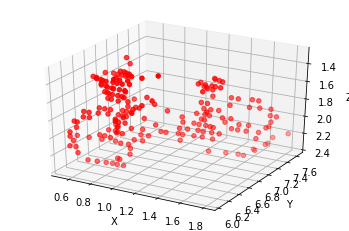

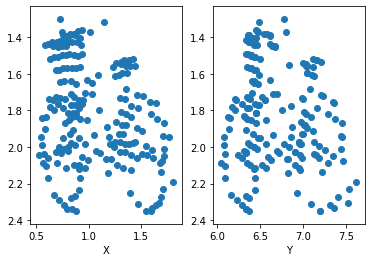

In [5]:
draw3D(rawSet[30])
draw2D(rawSet[30])

## Car

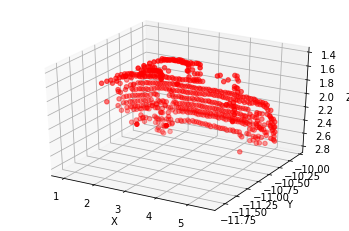

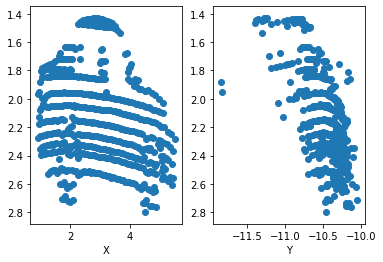

In [6]:
draw3D(rawSet[147])
draw2D(rawSet[147])

## Pedestrian

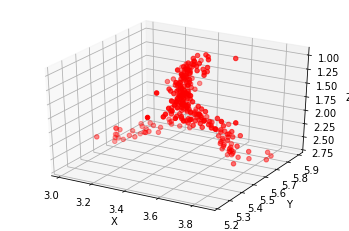

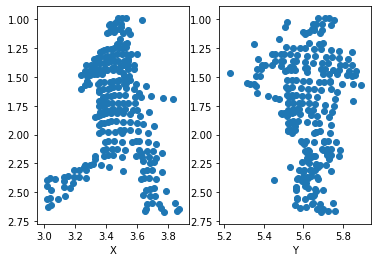

In [7]:
draw3D(rawSet[169])
draw2D(rawSet[169])

## Traffic light

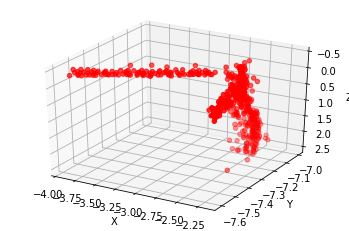

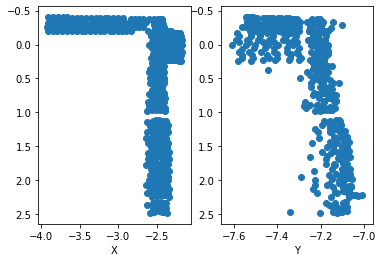

In [8]:
draw3D(rawSet[415])
draw2D(rawSet[415])

## Tree

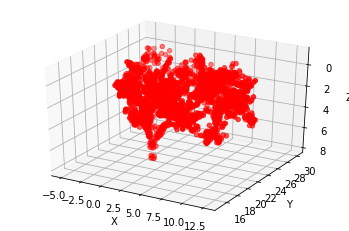

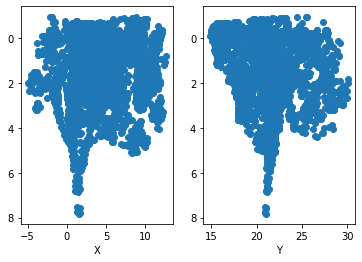

In [9]:
draw3D(rawSet[473])
draw2D(rawSet[473])

## Truck

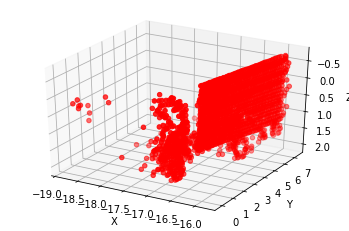

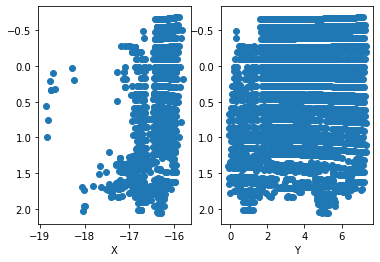

In [10]:
draw3D(rawSet[506])
draw2D(rawSet[506])

# Inbalanced data
There are 631 samples from 26 different classes and the data is very inbalanced

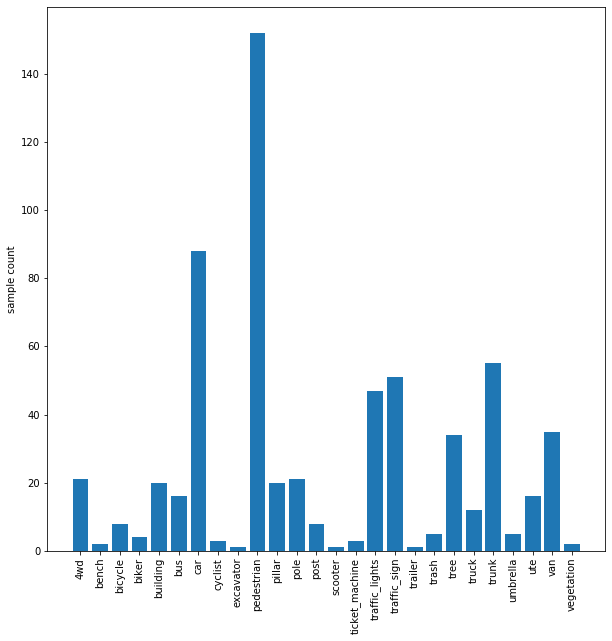

                sample count
4wd                       21
bench                      2
bicycle                    8
biker                      4
building                  20
bus                       16
car                       88
cyclist                    3
excavator                  1
pedestrian               152
pillar                    20
pole                      21
post                       8
scooter                    1
ticket_machine             3
traffic_lights            47
traffic_sign              51
trailer                    1
trash                      5
tree                      34
truck                     12
trunk                     55
umbrella                   5
ute                       16
van                       35
vegetation                 2


In [11]:
count, bins = np.histogram(label, bins = nClass, range=(0,nClass))
plt.figure(figsize=(10,10))
plt.bar(range(nClass),count)
plt.xticks(range(nClass), classes, rotation='vertical')
plt.ylabel('sample count')
plt.show()
print(pd.DataFrame(count, classes, ['sample count']))

# Binary classification
Combine 4wd, bus, car, truck, ute, and van into vehicle class, and use pedestrian class.

In [46]:
binarySet = []
binaryLabel = []
for i in range(len(rawSet)):
    l = classes[label[i]]
    if l == '4wd' or l == 'bus' or l == 'car' or l == 'truck' or l == 'ute' or l == 'van':
        binarySet.append(rawSet[i])
        binaryLabel.append(True)
    elif l == 'pedestrian':
        binarySet.append(rawSet[i])
        binaryLabel.append(False)


## Binary classification - shuffle and split data

In [47]:
def transformPts(pts):
    # 1x3 matrices for x,y,z min and max
    lowerBound = np.min(pts,axis=0)
    upperBound = np.max(pts,axis=0)+0.0001
    
    # rescale the range to 0-32
    scale = 32/(upperBound-lowerBound)
    
    # apply transformation
    newPts = (pts-lowerBound)*scale
    
    return newPts

def getFeatVec(pts):
    transPts = transformPts(pts)
    result = np.zeros((32,32,32))
    for pt in transPts:
        idx = np.floor(pt)
        idx = idx.astype(int)
        result[idx[0],idx[1],idx[2]] += 1
    
    return result


In [48]:
binaryPtCloudSetTrain, binaryPtCloudSetTest, binaryLabelTrain, binaryLabelTest = train_test_split(binarySet, binaryLabel, test_size = 0.2, random_state=13)
nTrain = len(binaryPtCloudSetTrain)
nTest = len(binaryPtCloudSetTest)

In [51]:
binaryVoxelSetTrain = np.zeros((nTrain, 32, 32, 32))
binaryVoxelSetTest = np.zeros((nTest, 32, 32, 32))

for i in range(nTrain):
    binaryVoxelSetTrain[i,:,:,:] = getFeatVec(binaryPtCloudSetTrain[i])
for i in range(nTest):
    binaryVoxelSetTest[i,:,:,:] = getFeatVec(binaryPtCloudSetTest[i])
    
# Expand feat vec for CONV3D
x_train = np.expand_dims(binaryVoxelSetTrain, axis = 4)
x_test = np.expand_dims(binaryVoxelSetTest, axis = 4)
y_train = binaryLabelTrain
y_test = binaryLabelTest

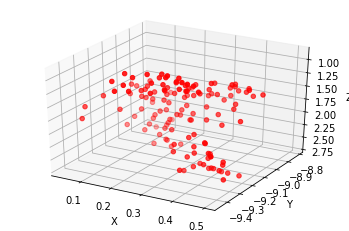

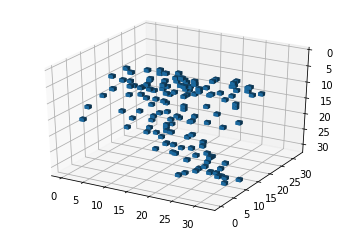

In [53]:
draw3D(binaryPtCloudSetTrain[0])
drawVoxel(binaryVoxelSetTrain[0,:,:,:])

## Binary classification - CNN model

In [54]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(5,5,5), input_shape=(32, 32, 32, 1), strides=(2,2,2)))
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(3,3,3)))
cnn_model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=128,activation='relu'))
cnn_model.add(keras.layers.Dense(units=1,activation='sigmoid'))
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 14, 14, 14, 2)     252       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 12, 12, 12, 2)     110       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 6, 6, 2)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               55424     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 55,915
Trainable params: 55,915
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = cnn_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Train on 272 samples, validate on 68 samples
Epoch 1/5
272/272 [==============================] - 2s 7ms/sample - loss: 0.6491 - acc: 0.5221 - val_loss: 0.5753 - val_acc: 0.5294
Epoch 2/5
272/272 [==============================] - 1s 5ms/sample - loss: 0.5463 - acc: 0.5662 - val_loss: 0.5108 - val_acc: 0.6029
Epoch 3/5
272/272 [==============================] - 1s 5ms/sample - loss: 0.4707 - acc: 0.7610 - val_loss: 0.4521 - val_acc: 0.8529
Epoch 4/5
272/272 [==============================] - 1s 5ms/sample - loss: 0.4098 - acc: 0.8897 - val_loss: 0.4109 - val_acc: 0.9118
Epoch 5/5
272/272 [==============================] - 1s 5ms/sample - loss: 0.3616 - acc: 0.9118 - val_loss: 0.3748 - val_acc: 0.9265


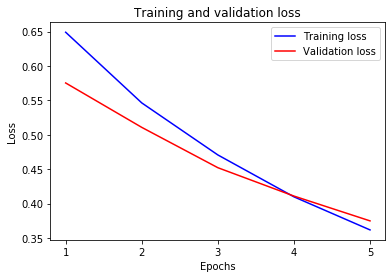

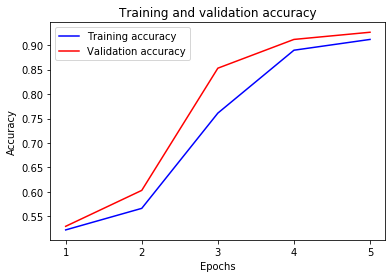

       loss       acc  val_loss   val_acc
0  0.649091  0.522059  0.575332  0.529412
1  0.546330  0.566176  0.510759  0.602941
2  0.470671  0.761029  0.452116  0.852941
3  0.409763  0.889706  0.410874  0.911765
4  0.361637  0.911765  0.374768  0.926471


In [56]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

print(pd.DataFrame(history_dict))

In [57]:
y_predict_prob = cnn_model.predict(x_test)
y_predict = y_predict_prob > 0.5

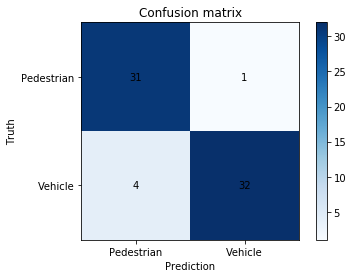

In [58]:
conf_matrix = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots()
ax.set_title('Confusion matrix')
ax.set_yticks([0,1])
ax.set_xticks([0,1])
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticklabels(['Pedestrian','Vehicle'])
ax.set_yticklabels(['Pedestrian','Vehicle'])
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="black")

## Binary classification - Prediction results

In [59]:
# Find examples of true pos, true neg, false pos, and false neg
for i in range(len(y_test)):
    if y_test[i] == True and y_predict[i] == True:
        tpIdx = i
        break
for i in range(len(y_test)):
    if y_test[i] == False and y_predict[i] == False:
        tnIdx = i
        break
for i in range(len(y_test)):
    if y_test[i] == False and y_predict[i] == True:
        fpIdx = i
        break
for i in range(len(y_test)):
    if y_test[i] == True and y_predict[i] == False:
        fnIdx = i
        break

## Binary classification - Successful classification - vehicle

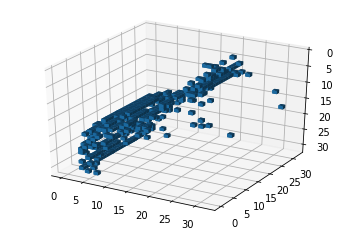

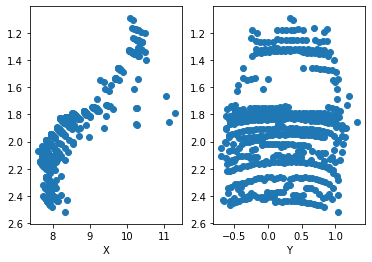

In [60]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[tpIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[tpIdx])

## Binary classification - Successful classification - pedestrian 

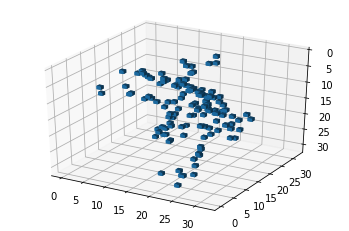

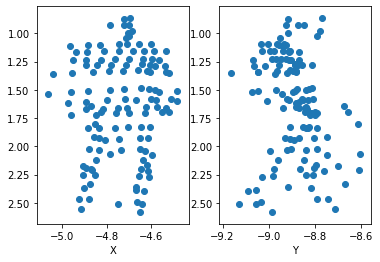

In [61]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[tnIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[tnIdx])

## Binary classification - Failed classification - pedestrian calssified as vehicle 

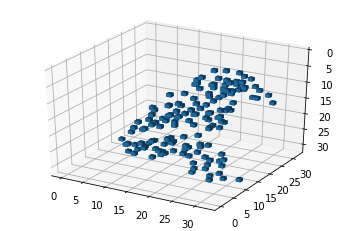

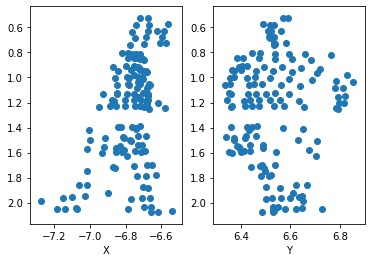

In [62]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[fpIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[fpIdx])

## Binary Classification - Failed classification - vehicle calssified as pedestrian 

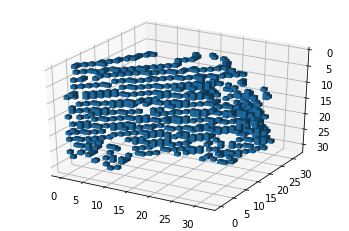

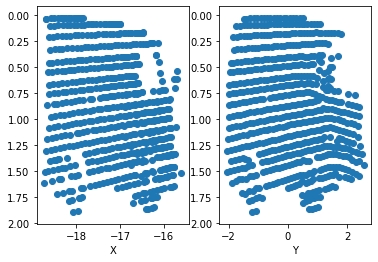

In [63]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(binaryVoxelSetTest[fnIdx])
ax.invert_zaxis()

draw2D(binaryPtCloudSetTest[fnIdx])

# Multi-class classification

In [64]:
supportedClassesDic = {'car':0,'pedestrian':1,'traffic_sign':2,'trunk':3}
supportedClasses = list(supportedClassesDic)


In [65]:
multiSet = []
multiLabel = []
for i in range(len(rawSet)):
    l = classes[label[i]]
    if l in supportedClassesDic:
        multiSet.append(rawSet[i])
        multiLabel.append(supportedClassesDic[l])
        
nMultiClass = len(supportedClasses)

## Multi-class classification - Shuffle and split data

In [66]:
multiPtCloudSetTrain, multiPtCloudSetTest, multiLabelTrain, multiLabelTest = train_test_split(multiSet, multiLabel, test_size = 0.2, random_state=13)
nTrain = len(multiPtCloudSetTrain)
nTest = len(multiPtCloudSetTest)

In [67]:
multiVoxelSetTrain = np.zeros((nTrain, 32, 32, 32))
multiVoxelSetTest = np.zeros((nTest, 32, 32, 32))

for i in range(nTrain):
    multiVoxelSetTrain[i,:,:,:] = getFeatVec(multiPtCloudSetTrain[i])
for i in range(nTest):
    multiVoxelSetTest[i,:,:,:] = getFeatVec(multiPtCloudSetTest[i])
    
# Expand feat vec for CONV3D
x_train = np.expand_dims(multiVoxelSetTrain, axis = 4)
x_test = np.expand_dims(multiVoxelSetTest, axis = 4)

y_train = keras.utils.to_categorical(multiLabelTrain)
y_test = keras.utils.to_categorical(multiLabelTest)

## Multi-class classification - CNN model

In [68]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(5,5,5), input_shape=(32, 32, 32, 1), strides=(2,2,2)))
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(3,3,3)))
cnn_model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=256,activation='relu'))
cnn_model.add(keras.layers.Dense(units=nMultiClass,activation='softmax'))
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 14, 14, 14, 2)     252       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 12, 12, 12, 2)     110       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 6, 6, 2)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               110848    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1028      
Total params: 112,238
Trainable params: 112,238
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = cnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Train on 276 samples, validate on 70 samples
Epoch 1/10
276/276 [==============================] - 2s 6ms/sample - loss: 1.3344 - acc: 0.3297 - val_loss: 1.1524 - val_acc: 0.6714
Epoch 2/10
276/276 [==============================] - 1s 5ms/sample - loss: 1.1581 - acc: 0.6268 - val_loss: 1.0357 - val_acc: 0.7286
Epoch 3/10
276/276 [==============================] - 1s 5ms/sample - loss: 1.0547 - acc: 0.6486 - val_loss: 0.9724 - val_acc: 0.7000
Epoch 4/10
276/276 [==============================] - 1s 5ms/sample - loss: 0.9598 - acc: 0.7174 - val_loss: 0.9256 - val_acc: 0.7714
Epoch 5/10
276/276 [==============================] - 1s 5ms/sample - loss: 0.8832 - acc: 0.7790 - val_loss: 0.8826 - val_acc: 0.7857
Epoch 6/10
276/276 [==============================] - 1s 5ms/sample - loss: 0.8172 - acc: 0.7790 - val_loss: 0.8420 - val_acc: 0.7429
Epoch 7/10
276/276 [==============================] - 1s 5ms/sample - loss: 0.7466 - acc: 0.7717 - val_loss: 0.7677 - val_acc: 0.7429
Epoch 8/10
276/27

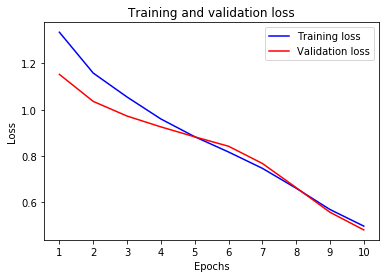

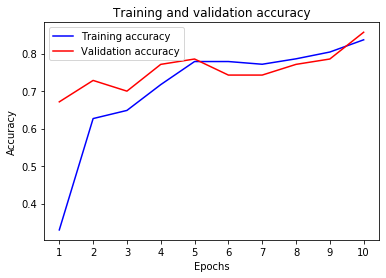

       loss       acc  val_loss   val_acc
0  1.334444  0.329710  1.152382  0.671429
1  1.158086  0.626812  1.035696  0.728571
2  1.054650  0.648551  0.972373  0.700000
3  0.959795  0.717391  0.925577  0.771429
4  0.883215  0.778986  0.882595  0.785714
5  0.817195  0.778986  0.841993  0.742857
6  0.746644  0.771739  0.767719  0.742857
7  0.660608  0.786232  0.663220  0.771429
8  0.568720  0.804348  0.556806  0.785714
9  0.496935  0.836957  0.480495  0.857143


In [70]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

print(pd.DataFrame(history_dict))

## Multi-class classification - confusion matrix

In [71]:
y_predict_prob = cnn_model.predict(x_test)
y_predict = np.argmax(y_predict_prob,axis=1)

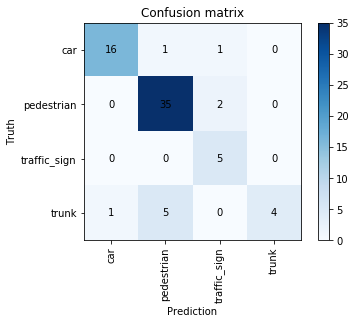

In [72]:
conf_matrix = confusion_matrix(multiLabelTest, y_predict)
fig, ax = plt.subplots()
ax.set_title('Confusion matrix')
ax.set_yticks(range(nMultiClass))
ax.set_xticks(range(nMultiClass))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticklabels(supportedClasses, rotation='vertical')
ax.set_yticklabels(supportedClasses)
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")
for i in range(nMultiClass):
    for j in range(nMultiClass):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="black")

In [73]:
acc = []
for i in range(nMultiClass):
    c = conf_matrix[i,i]
    s = np.sum(conf_matrix[i,:])
    acc.append(c/s)
pd.DataFrame(acc, supportedClasses, ['Accuracy'])

,Accuracy
car,0.888889
pedestrian,0.945946
traffic_sign,1.000000
trunk,0.400000


# Classification with 23 classes

In [76]:
supportedClasses = ['4wd',
    'bench',
    'bicycle',
    'biker',
    'building',
    'bus',
    'car',
    'cyclist',
    'pedestrian',
    'pillar',
    'pole',
    'post',
    'ticket_machine',
    'traffic_lights',
    'traffic_sign',
    'trash',
    'tree',
    'truck',
    'trunk',
    'umbrella',
    'ute',
    'van',
    'vegetation']

supportedClassDict = {}
count = 0
for c in supportedClasses:
    supportedClassesDic[c] = count
    count += 1

allSet = []
allLabel = []
for i in range(len(rawSet)):
    l = classes[label[i]]
    if l in supportedClassesDic:
        allSet.append(rawSet[i])
        allLabel.append(supportedClassesDic[l])
        
nMultiClass = len(supportedClasses)

ptCloudSetTrain, ptCloudSetTest, labelTrain, labelTest = train_test_split(allSet, allLabel, test_size = 0.2, random_state=13)
nTrain = len(ptCloudSetTrain)
nTest = len(ptCloudSetTest)

In [78]:
voxelSetTrain = np.zeros((nTrain, 32, 32, 32))
voxelSetTest = np.zeros((nTest, 32, 32, 32))

for i in range(nTrain):
    voxelSetTrain[i,:,:,:] = getFeatVec(ptCloudSetTrain[i])
for i in range(nTest):
    voxelSetTest[i,:,:,:] = getFeatVec(ptCloudSetTest[i])
    
# Expand feat vec for CONV3D
x_train = np.expand_dims(voxelSetTrain, axis = 4)
x_test = np.expand_dims(voxelSetTest, axis = 4)

y_train = np.zeros((nTrain,nMultiClass))
y_test = np.zeros((nTest,nMultiClass))

for i in range(nTrain):
    l = labelTrain[i]
    y_train[i,l] = 1
for i in range(nTest):
    l = labelTest[i]
    y_test[i,l] = 1

## CNN model

In [79]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(5,5,5), input_shape=(32, 32, 32, 1), strides=(2,2,2)))
cnn_model.add(keras.layers.Conv3D(2, kernel_size=(3,3,3)))
cnn_model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(units=256,activation='relu'))
cnn_model.add(keras.layers.Dense(units=nMultiClass,activation='softmax'))
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['acc'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 14, 14, 14, 2)     252       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 12, 12, 12, 2)     110       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 6, 6, 6, 2)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               110848    
_________________________________________________________________
dense_11 (Dense)             (None, 23)                5911      
Total params: 117,121
Trainable params: 117,121
Non-trainable params: 0
_________________________________________________________________


### Adjust loss function based on class instance nubmers 

In [80]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labelTrain),
                                                 labelTrain)

In [81]:
history = cnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), class_weight=class_weights)

Train on 502 samples, validate on 126 samples
Epoch 1/10
502/502 [==============================] - 3s 6ms/sample - loss: 3.0357 - acc: 0.2390 - val_loss: 2.8717 - val_acc: 0.3492
Epoch 2/10
502/502 [==============================] - 2s 5ms/sample - loss: 2.7131 - acc: 0.3267 - val_loss: 2.6397 - val_acc: 0.3810
Epoch 3/10
502/502 [==============================] - 2s 5ms/sample - loss: 2.5003 - acc: 0.3526 - val_loss: 2.5418 - val_acc: 0.3889
Epoch 4/10
502/502 [==============================] - 2s 5ms/sample - loss: 2.3610 - acc: 0.3884 - val_loss: 2.5010 - val_acc: 0.4603
Epoch 5/10
502/502 [==============================] - 2s 5ms/sample - loss: 2.2254 - acc: 0.4382 - val_loss: 2.4235 - val_acc: 0.4603
Epoch 6/10
502/502 [==============================] - 2s 5ms/sample - loss: 2.0958 - acc: 0.4562 - val_loss: 2.3666 - val_acc: 0.4762
Epoch 7/10
502/502 [==============================] - 2s 5ms/sample - loss: 1.9658 - acc: 0.5279 - val_loss: 2.3568 - val_acc: 0.4683
Epoch 8/10
502/5

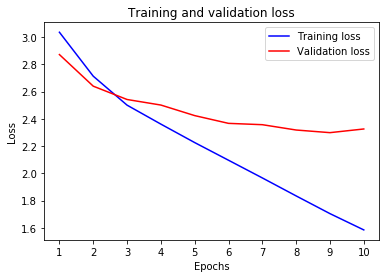

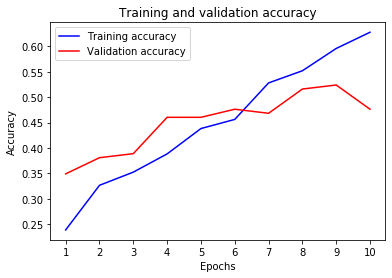

       loss       acc  val_loss   val_acc
0  3.035666  0.239044  2.871657  0.349206
1  2.713077  0.326693  2.639681  0.380952
2  2.500336  0.352590  2.541803  0.388889
3  2.360983  0.388446  2.501026  0.460317
4  2.225448  0.438247  2.423503  0.460317
5  2.095776  0.456175  2.366555  0.476190
6  1.965835  0.527888  2.356772  0.468254
7  1.833738  0.551793  2.317644  0.515873
8  1.703642  0.595618  2.298327  0.523810
9  1.584054  0.627490  2.325288  0.476190


In [85]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

print(pd.DataFrame(history_dict))

## Confusion matrix

In [82]:
y_predict_prob = cnn_model.predict(x_test)
y_predict = np.argmax(y_predict_prob,axis=1)

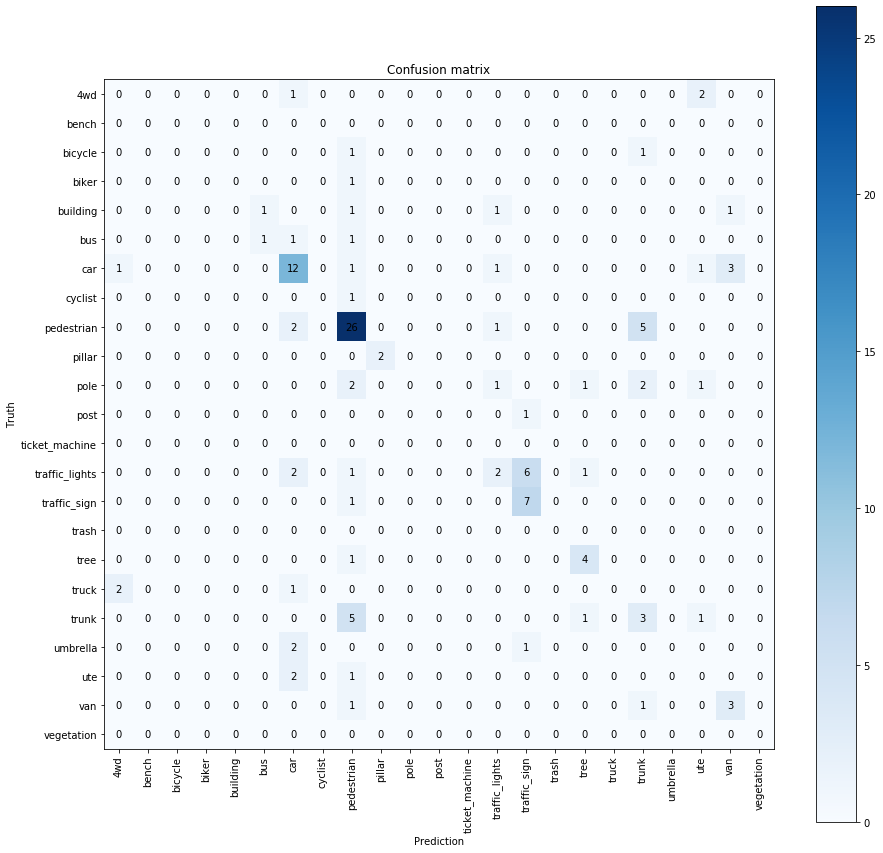

In [83]:
conf_matrix = confusion_matrix(labelTest, y_predict, range(nMultiClass))
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Confusion matrix')
ax.set_yticks(range(nMultiClass))
ax.set_xticks(range(nMultiClass))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticklabels(supportedClasses, rotation='vertical')
ax.set_yticklabels(supportedClasses)
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")
for i in range(nMultiClass):
    for j in range(nMultiClass):
        ax.text(j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="black")

In [84]:
acc = []
for i in range(nMultiClass):
    c = conf_matrix[i,i]
    s = np.sum(conf_matrix[i,:])
    if s != 0:
        acc.append(c/s)
    else:
        acc.append('NaN')
pd.DataFrame(acc, supportedClasses, ['Accuracy'])

,Accuracy
4wd,0
bench,NaN
bicycle,0
biker,0
building,0
bus,0.333333
car,0.631579
cyclist,0
pedestrian,0.764706
pillar,1
